In [1]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn import metrics
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, Normalizer, PowerTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.feature_selection import SelectPercentile
from sklearn.linear_model import (
    LogisticRegression, 
    LinearRegression,
    LogisticRegressionCV)
from sklearn.pipeline import make_pipeline
from IPython.display import display
pd.options.display.max_columns = None

# Predictive Modelling

## Exercise 1: Face Recognition (but not as evil this time)

Using the faces dataset in:

```
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
```

If you use the `faces.target` and `faces.target_names` attributes, you can build a facial recognition algorithm.

Use sklearn **gridsearch** (or an equivalent, like random search) to optimize the model for accuracy. Try both a SVM-based classifier and a logistic regression based classifier (with a feature pipeline of your choice) to get the best model. You should have at least 75-80% accuracy.

In [5]:
# exercise 1
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
faces_c = fetch_lfw_people(min_faces_per_person=60, color=True)

In [3]:
faces.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [4]:
# the number of samples for each face are quite imbalanced with target 6 only having 60 samples
# if the data were more imbalanced it might be good to try oversampling to correct it but I decided not to do that here
info = pd.DataFrame(np.unique(faces.target, return_counts=True), index=['target', 'n_samples'], columns=faces.target_names).T
info['%'] = (info.n_samples/np.unique(faces.target, return_counts=True)[1].sum()*100).round(1)
info

,target,n_samples,%
Ariel Sharon,0,77,5.7
Colin Powell,1,236,17.5
Donald Rumsfeld,2,121,9.0
George W Bush,3,530,39.3
Gerhard Schroeder,4,109,8.1
Hugo Chavez,5,71,5.3
Junichiro Koizumi,6,60,4.5
Tony Blair,7,144,10.7


In [5]:
X = faces.data
y = faces.target

# stratify on y to ensure the percentages of each target are matched in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=10)

#### Logistic Regression Model
- Initially tested a pipeline with scaling and dimentionality reduction, but these models had very poor results.
- Tried different solvers but the huge increase in time made anything but lbfgs and liblinear too long to perform grid search on. The liblinear solver also is not compatible with multinomial multi class and 'none' penalty so was tested but excluded from final code to save time since the lbfgs solver was found to be best anyway. 

In [6]:
# parameters to test in grid search
params = {'penalty': ['l2', 'none'],
          'C': [1e-6, 1e-5, 1e-4],
          'multi_class': ['multinomial', 'ovr'],
          'class_weight': ['balanced', None]}

classifier =  LogisticRegression(random_state=10, max_iter=2000)

grid = GridSearchCV(classifier, params, cv=2, n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


In [7]:
print(grid.best_params_)

{'C': 1e-05, 'class_weight': 'balanced', 'multi_class': 'ovr', 'penalty': 'l2'}


In [8]:
y_pred_lr = grid.predict(X_test)


Classification report
-------------------
              precision    recall  f1-score   support

           0       0.85      0.89      0.87        19
           1       0.85      0.90      0.88        59
           2       0.88      0.77      0.82        30
           3       0.90      0.92      0.91       133
           4       0.79      0.96      0.87        27
           5       0.93      0.72      0.81        18
           6       0.93      0.87      0.90        15
           7       0.90      0.78      0.84        36

    accuracy                           0.88       337
   macro avg       0.88      0.85      0.86       337
weighted avg       0.88      0.88      0.88       337

Jaccard Scores
-------------------
		0: 0.77
		1: 0.78
		2: 0.70
		3: 0.84
		4: 0.76
		5: 0.68
		6: 0.81
		7: 0.72
Weighted Average : 0.78


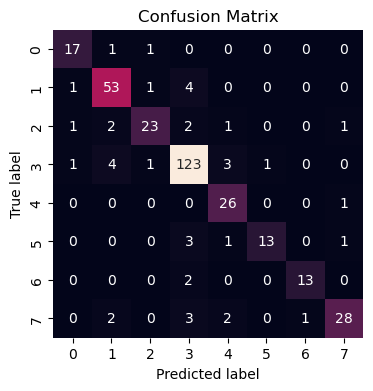

In [9]:
# metrics for logistic regression model
print(f'\nClassification report\n-------------------\n{metrics.classification_report(y_test, y_pred_lr)}')
print(f'Jaccard Scores\n-------------------')
jaccard_all = metrics.jaccard_score(y_test, y_pred_lr, average=None)
for i in range(len(jaccard_all)):
    print(f'\t\t{i}: {jaccard_all[i]:.2f}')
print(f'Weighted Average : {metrics.jaccard_score(y_test, y_pred_lr, average="weighted"):.2f}')
fig, (ax1) = plt.subplots(1, 1, figsize=(4,4))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d", ax=ax1, cbar=False)
ax1.set_xlabel('Predicted label')
ax1.set_ylabel('True label')
ax1.set_title('Confusion Matrix')
plt.show()

#### Interpretation
The results of the logistic regression are acceptable with the best performer being the face with the most samples. However, even with the low sample size for face 6, the f1 score is still 0.90. The Jaccard score is a metric that essentially calculates the number of successful classifications over the number of successes plus false negative and false positives, ignoring true negatives in the calculation. This seems very useful for determining how successful the model is at minimizing <i>all</i> misclassifications, whereas precision and recall, and by extension f1 score, are looking at true positive ratios independently. So the Jaccard score shows that target 5 was much more misclassified overall than the other targets. The weighted average Jaccard score is simply the average of the individual scores and gives the impression that the model was still reasonably successful. 

#### SVM Model
- Surprisingly the SVM model was more difficult to get to work properly. Initial attemps had predictions of only one or two faces.
- I tried normalizers and other scalers but PCA was the only option that gave decent results.

In [10]:
scaler = PCA()
X_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
# parameters for SVM model
pipeline = Pipeline([
    ('pca', PCA(random_state=10)),
    ('clf', SVC(random_state=10))
])

params = {'pca__n_components': [None, 500, 150],
          'pca__whiten': [True, False],
          'clf__gamma': ['scale', 'auto', 1e-8],
          'clf__kernel': ['rbf', 'linear'],
          'clf__C': [100, 10, 1, 0.1],
          'clf__class_weight': ['balanced', None],
          'clf__break_ties': [False, True]
         }

grid_svm = GridSearchCV(pipeline, params, cv=2, n_jobs=-1, verbose=2).fit(X_train, y_train)

Fitting 2 folds for each of 576 candidates, totalling 1152 fits


In [12]:
print(grid_svm.best_params_)

{'clf__C': 100, 'clf__break_ties': True, 'clf__class_weight': 'balanced', 'clf__gamma': 1e-08, 'clf__kernel': 'rbf', 'pca__n_components': None, 'pca__whiten': False}


In [13]:
y_pred_svm = grid_svm.predict(X_test)


Classification report
-------------------
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        19
           1       0.79      0.90      0.84        59
           2       0.89      0.80      0.84        30
           3       0.92      0.89      0.91       133
           4       0.81      0.81      0.81        27
           5       0.73      0.61      0.67        18
           6       1.00      0.93      0.97        15
           7       0.79      0.83      0.81        36

    accuracy                           0.86       337
   macro avg       0.84      0.83      0.83       337
weighted avg       0.86      0.86      0.86       337

Jaccard Scores
-------------------
		0: 0.70
		1: 0.73
		2: 0.73
		3: 0.83
		4: 0.69
		5: 0.50
		6: 0.93
		7: 0.68
Weighted Average : 0.76


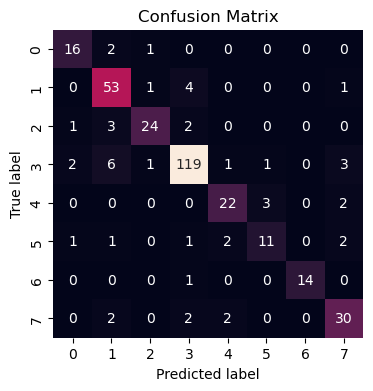

In [14]:
# metrics for SVM model
print(f'\nClassification report\n-------------------\n{metrics.classification_report(y_test, y_pred_svm)}')
print(f'Jaccard Scores\n-------------------')
jaccard_all = metrics.jaccard_score(y_test, y_pred_svm, average=None)
for i in range(len(jaccard_all)):
    print(f'\t\t{i}: {jaccard_all[i]:.2f}')
print(f'Weighted Average : {metrics.jaccard_score(y_test, y_pred_svm, average="weighted"):.2f}')
fig, (ax1) = plt.subplots(1, 1, figsize=(4,4))
sns.heatmap(metrics.confusion_matrix(y_test, y_pred_svm), annot=True, fmt="d", ax=ax1, cbar=False)
ax1.set_xlabel('Predicted label')
ax1.set_ylabel('True label')
ax1.set_title('Confusion Matrix')
plt.show()

#### Interpretation
SVC had slightly worse overall classification than logistic regression. Similar to LR, face 5 had the worst results but SVC did much better on face 6, only misclassifying 1 image. This was the only improvement, however. All other targets had worse results. I'm a bit confused why this model didn't perform as well, especially since some sources said an SVM should be better for image classification. The other consideration is that the number of features is larger than the number of training examples so sources say to use logistic regression in these cases. 